In [1]:
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from save_result import  save_scores_to_file

#get data to pandas
dataset = pd.read_csv("./data/bank-classification.csv")


#take only data with known prediction
data = dataset[dataset['y'] != 'unknown']
data = data.replace({'y':{'yes':1, 'no' : 0}})
data.drop('id',axis= 1, inplace = True)

(array([ 280., 3817., 6841., 4550., 3272., 1676.,  186.,  111.,   51.,
          15.]),
 array([17. , 24.9, 32.8, 40.7, 48.6, 56.5, 64.4, 72.3, 80.2, 88.1, 96. ]),
 <a list of 10 Patch objects>)

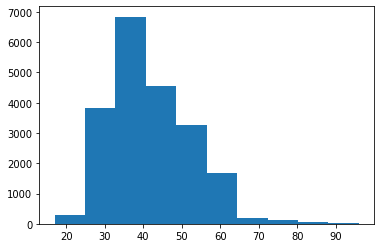

In [2]:
# BIRTH_DATE AGE DAYS_SINCE_LAST_CONTACT
#change contact_date and birth_date to age or days_since_last_contact
reference_data =  pd.Timestamp(data['contact_date'].max())
data['days_since_last_contact']= (reference_data - pd.to_datetime(data['contact_date'])).dt.days
data['age']= ((reference_data - pd.to_datetime(data['birth_date'])).dt.days / 365).astype(int)
data.drop('birth_date',axis=1, inplace =True)
data.drop('contact_date',axis=1, inplace =True)

#mostly 30-50 years
plt.hist(data['age'])

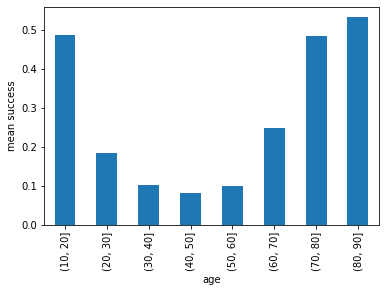

In [3]:
# but they aren't interested in campaign
plot = data.groupby(pd.cut(data['age'], np.arange(10,100,10)))['y'].mean().plot(kind='bar')
plot.set_xlabel("age")
plot.set_ylabel("mean success")
plt.show()
#exist strong dependence between y and age

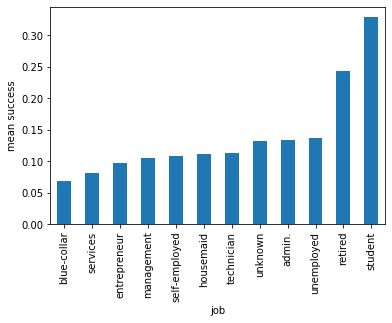

In [3]:
# JOB
plot = data.groupby('job')['y'].mean().sort_values().plot(kind='bar')
data.groupby('job')['y'].mean().sort_values()

plot.set_xlabel("job")
plot.set_ylabel("mean success")
plt.show()
# retired and student has higher coefficient, but supposedly it imply from age

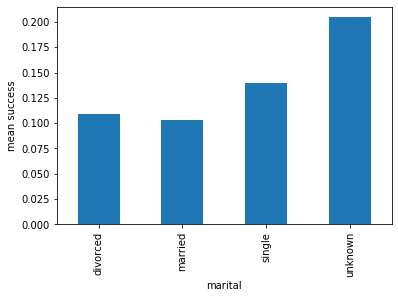

In [5]:
# MARITAL
plot = data.groupby('marital')['y'].mean().plot(kind='bar')
plot.set_xlabel("marital")
plot.set_ylabel("mean success")
plt.show()

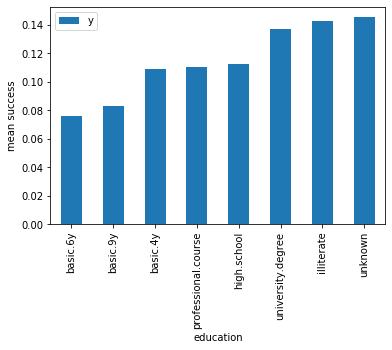

array(['basic.4y', 'high.school', 'basic.9y', 'unknown',
       'professional.course', 'basic.6y', 'university.degree',
       'illiterate'], dtype=object)

In [4]:
# EDUCATION

job_df = pd.DataFrame(data.groupby('education')['y'].mean().sort_values())
plot = job_df.plot(kind='bar')
plot.set_xlabel("education")
plot.set_ylabel("mean success")
plt.show()

data['education'].unique()


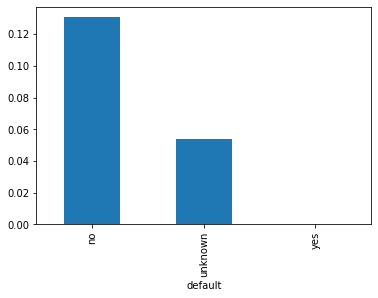

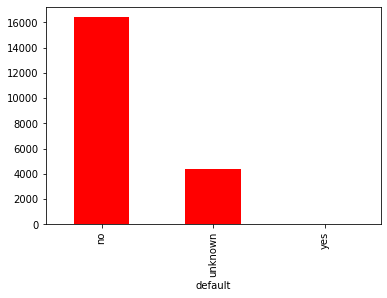

In [5]:
# DEFAULT
data.groupby('default')['y'].mean().plot(kind='bar').plot()
data.groupby('default').count().plot(kind='bar',color='red',legend=None)

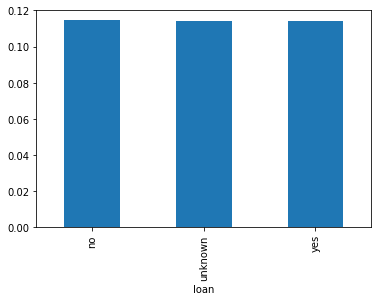

In [6]:
# LOAN
plot = data.groupby('loan')['y'].mean().plot(kind='bar').plot()


[]

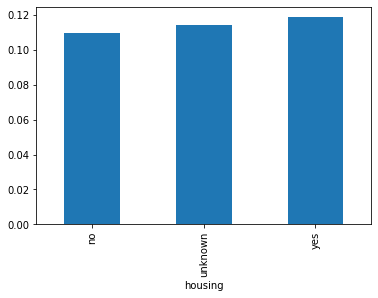

In [7]:
# HOUSING
data.groupby('housing')['y'].mean().plot(kind='bar').plot()

<bound method Axes.plot of <matplotlib.axes._subplots.AxesSubplot object at 0x7fb78dbcfa20>>

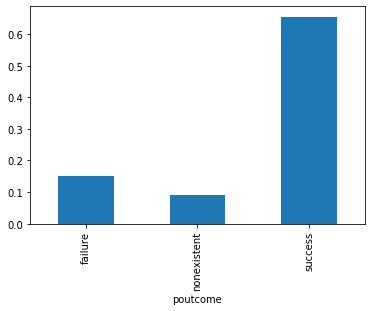

In [8]:
# POUTCOME
pd_da = data[['poutcome','y']]
data.groupby('poutcome')['y'].mean().plot(kind='bar').plot

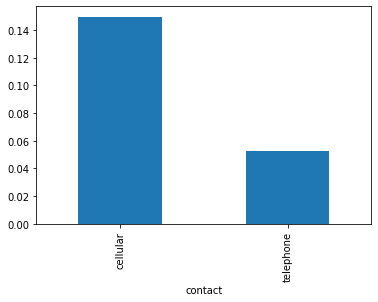

In [9]:
# CONTACT
plot = data.groupby('contact')['y'].mean().plot(kind='bar').plot()
data['contact'] = pd.factorize(data['contact'])[0]

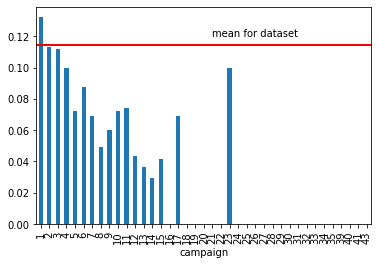

In [10]:
# CAMPAIGN
plt.text(20,0.12,'mean for dataset')
plt.hlines(y=data['y'].mean(),xmin=-1,xmax=100, linewidth=2, color='r',label='mean all dataset')
data.groupby('campaign')['y'].mean().plot(kind='bar')
# as we can see number of calling in campaign is inversely proportional to probability of success 

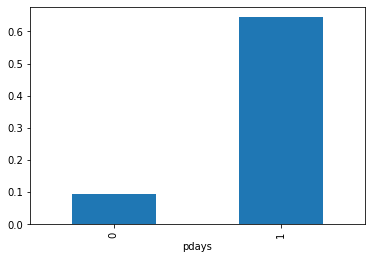

In [11]:
#pdays and previous is irrelevant to this problem, bc concerns about last campaign
# PDAYS
data.loc[data['pdays'] == 999,['pdays']] = 0
data.loc[data['pdays'] != 0,['pdays']] = 1
data.groupby('pdays')['y'].mean().plot(kind='bar')


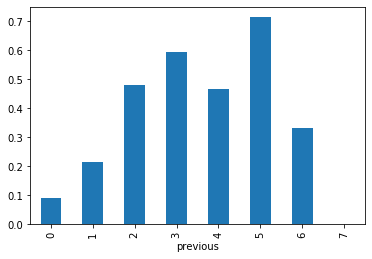

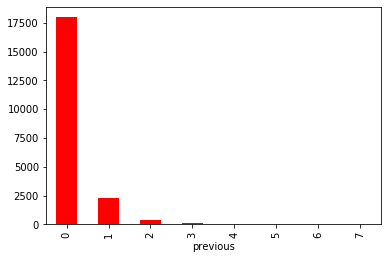

In [12]:
# PREVIOUS
data.groupby('previous')['y'].mean().plot(kind='bar')
data.groupby('previous').count().plot(kind='bar',color='red',legend=None)
#previous is irelevant to this campaign, and small number of samples are greater than 2 

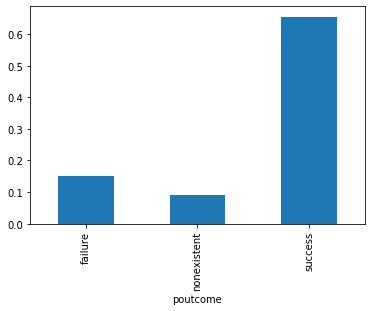

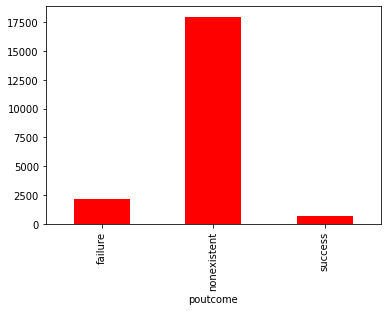

In [13]:
data.groupby('poutcome')['y'].mean().plot(kind='bar')
data.groupby('poutcome').count().plot(kind='bar',color='red',legend=None)
# nonexistent value is mojarant, so this feature is negligible  

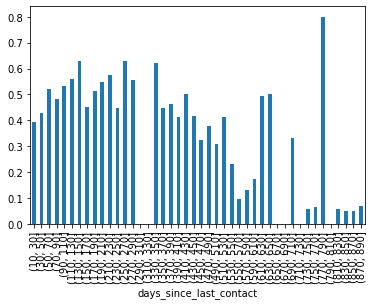

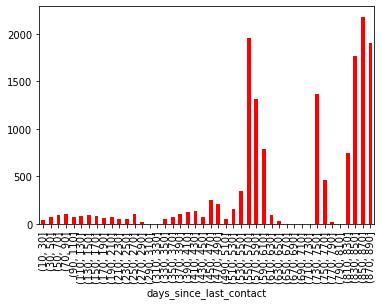

In [14]:
# We can see, that campaign calls are fluctuating in time.
data.groupby(pd.cut(data['days_since_last_contact'], np.arange(10,900,20)))['y'].mean().plot(kind= 'bar')
data.groupby(pd.cut(data['days_since_last_contact']
                    , np.arange(10,900,20))).count().plot(kind='bar',color='red',legend=None)

/home/abs/Projects/ML_JNP/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


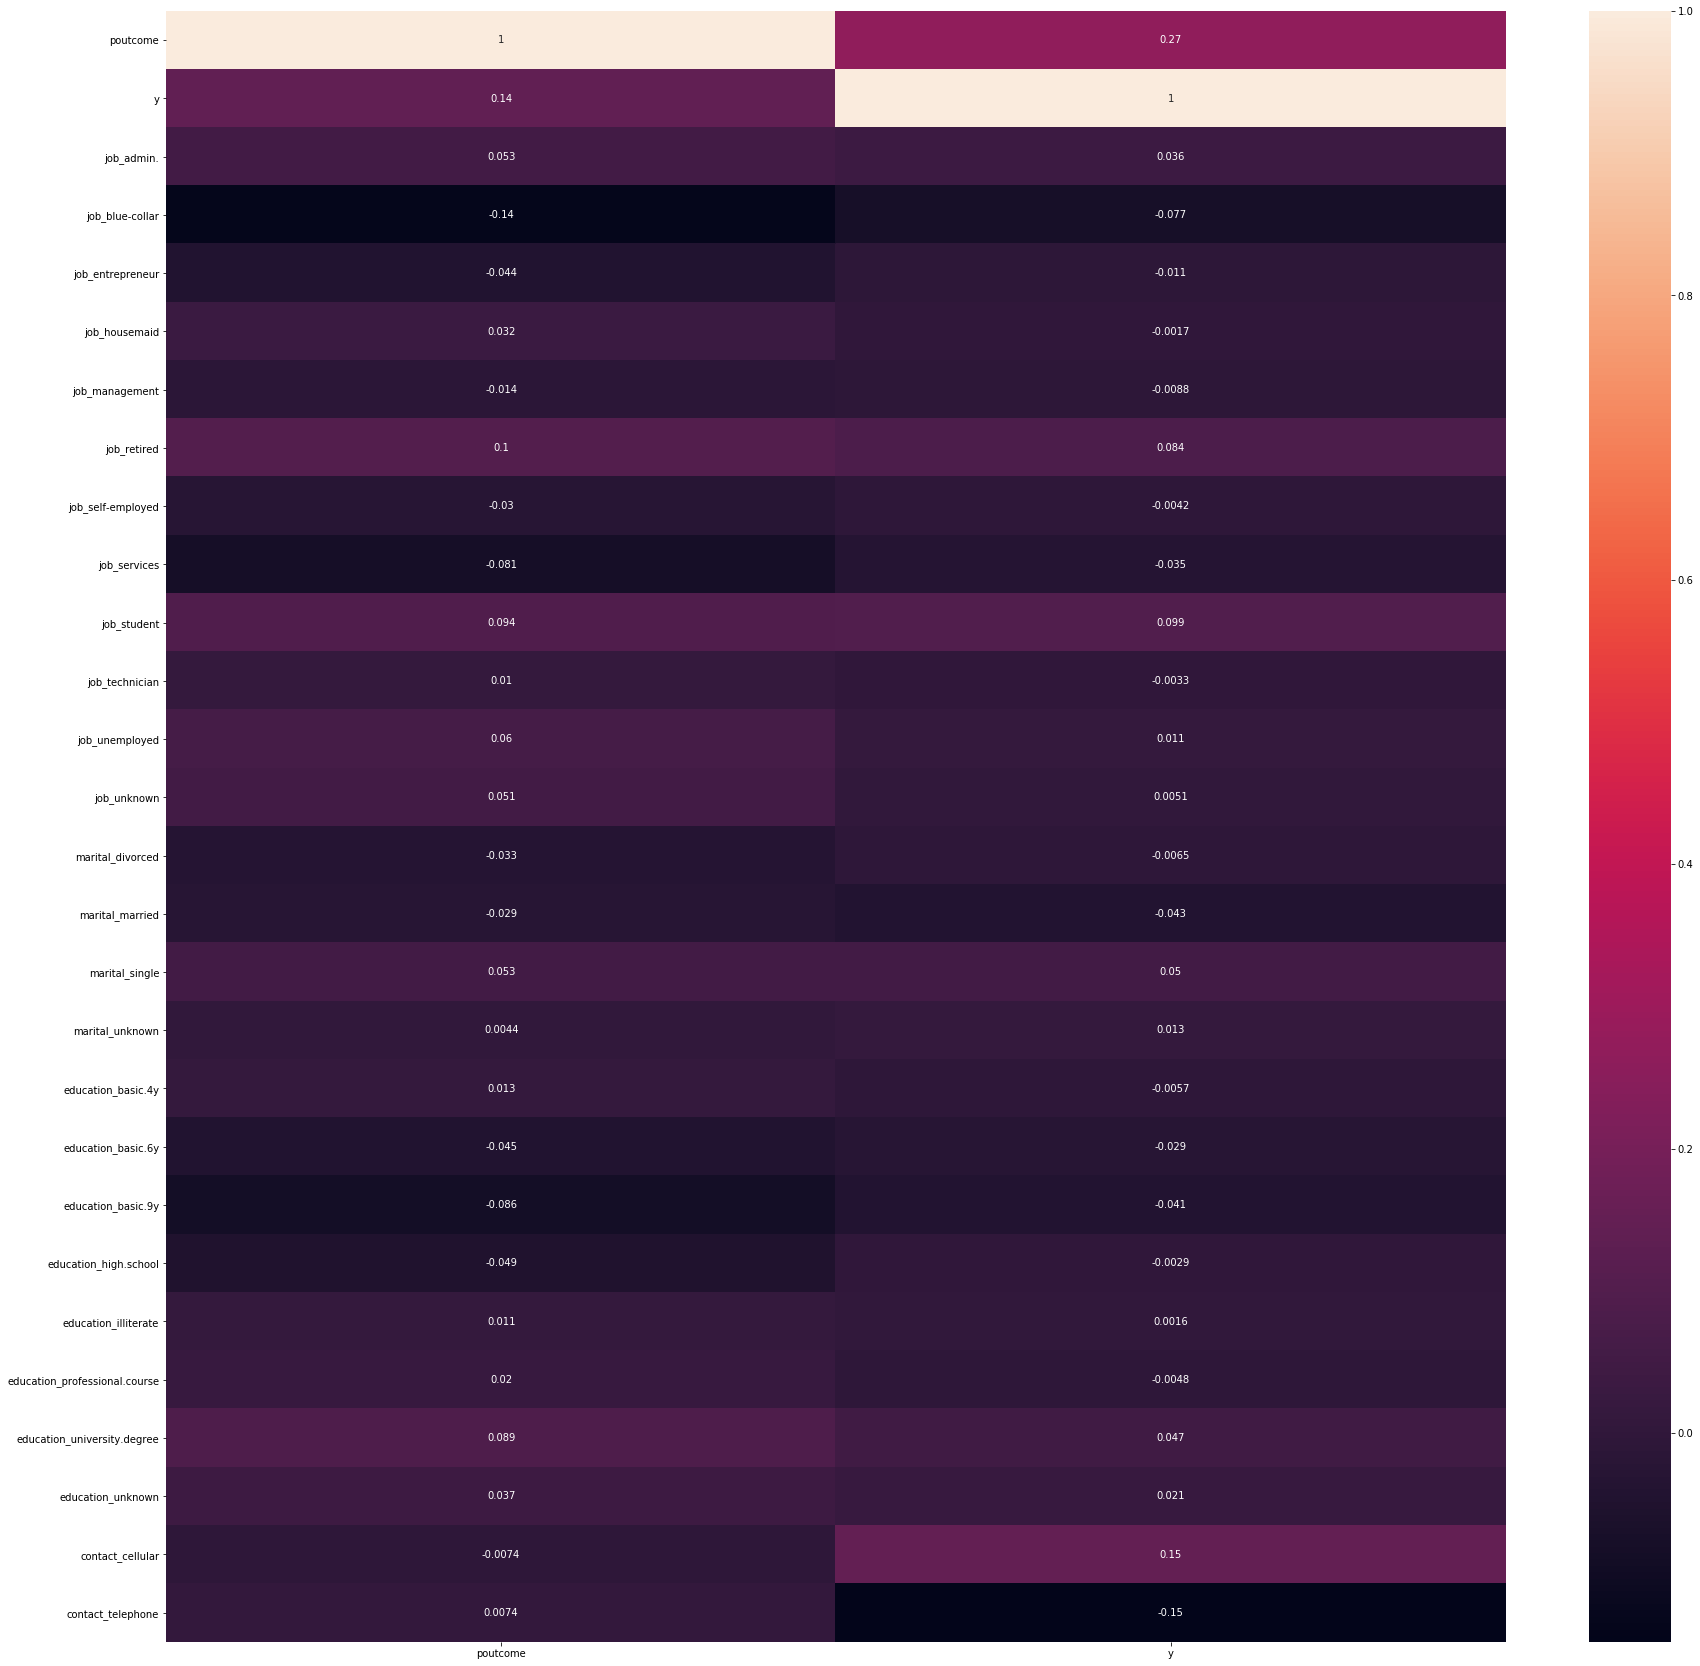

In [15]:
#Comparing correlations beetween current campaign and previous, maksimum set in known y and known poutcome

pd_corr = dataset[['job','marital','education','contact','poutcome','y']]
pd_corr = pd.get_dummies(pd_corr,columns=['job'])
pd_corr = pd.get_dummies(pd_corr,columns=['marital'])
pd_corr = pd.get_dummies(pd_corr,columns=['education'])
pd_corr = pd.get_dummies(pd_corr,columns=['contact'])

pd_corr = pd_corr.replace({'yes': 1, 'no': 0,'nonexistent': -1,'success':1,'failure':0,'unknown':-1})

pd_poutcome = pd_corr.loc[pd_corr['poutcome'] != -1]
pd_y = pd_corr.loc[pd_corr['y'] != -1]
pd_poutcome['poutcome'] = pd.to_numeric(pd_poutcome['poutcome'])

corr_poutcome = pd.DataFrame(pd_poutcome.corr()['poutcome'])
corr_y = pd.DataFrame(pd_y.corr()['y'])

corr = corr_poutcome.merge(corr_y, left_index=True, right_index=True)
fig, ax = plt.subplots(figsize=(30,30))   
svm = sn.heatmap(corr, annot=True)
fig.savefig('./poutcome_vs_y.png', dpi=200)

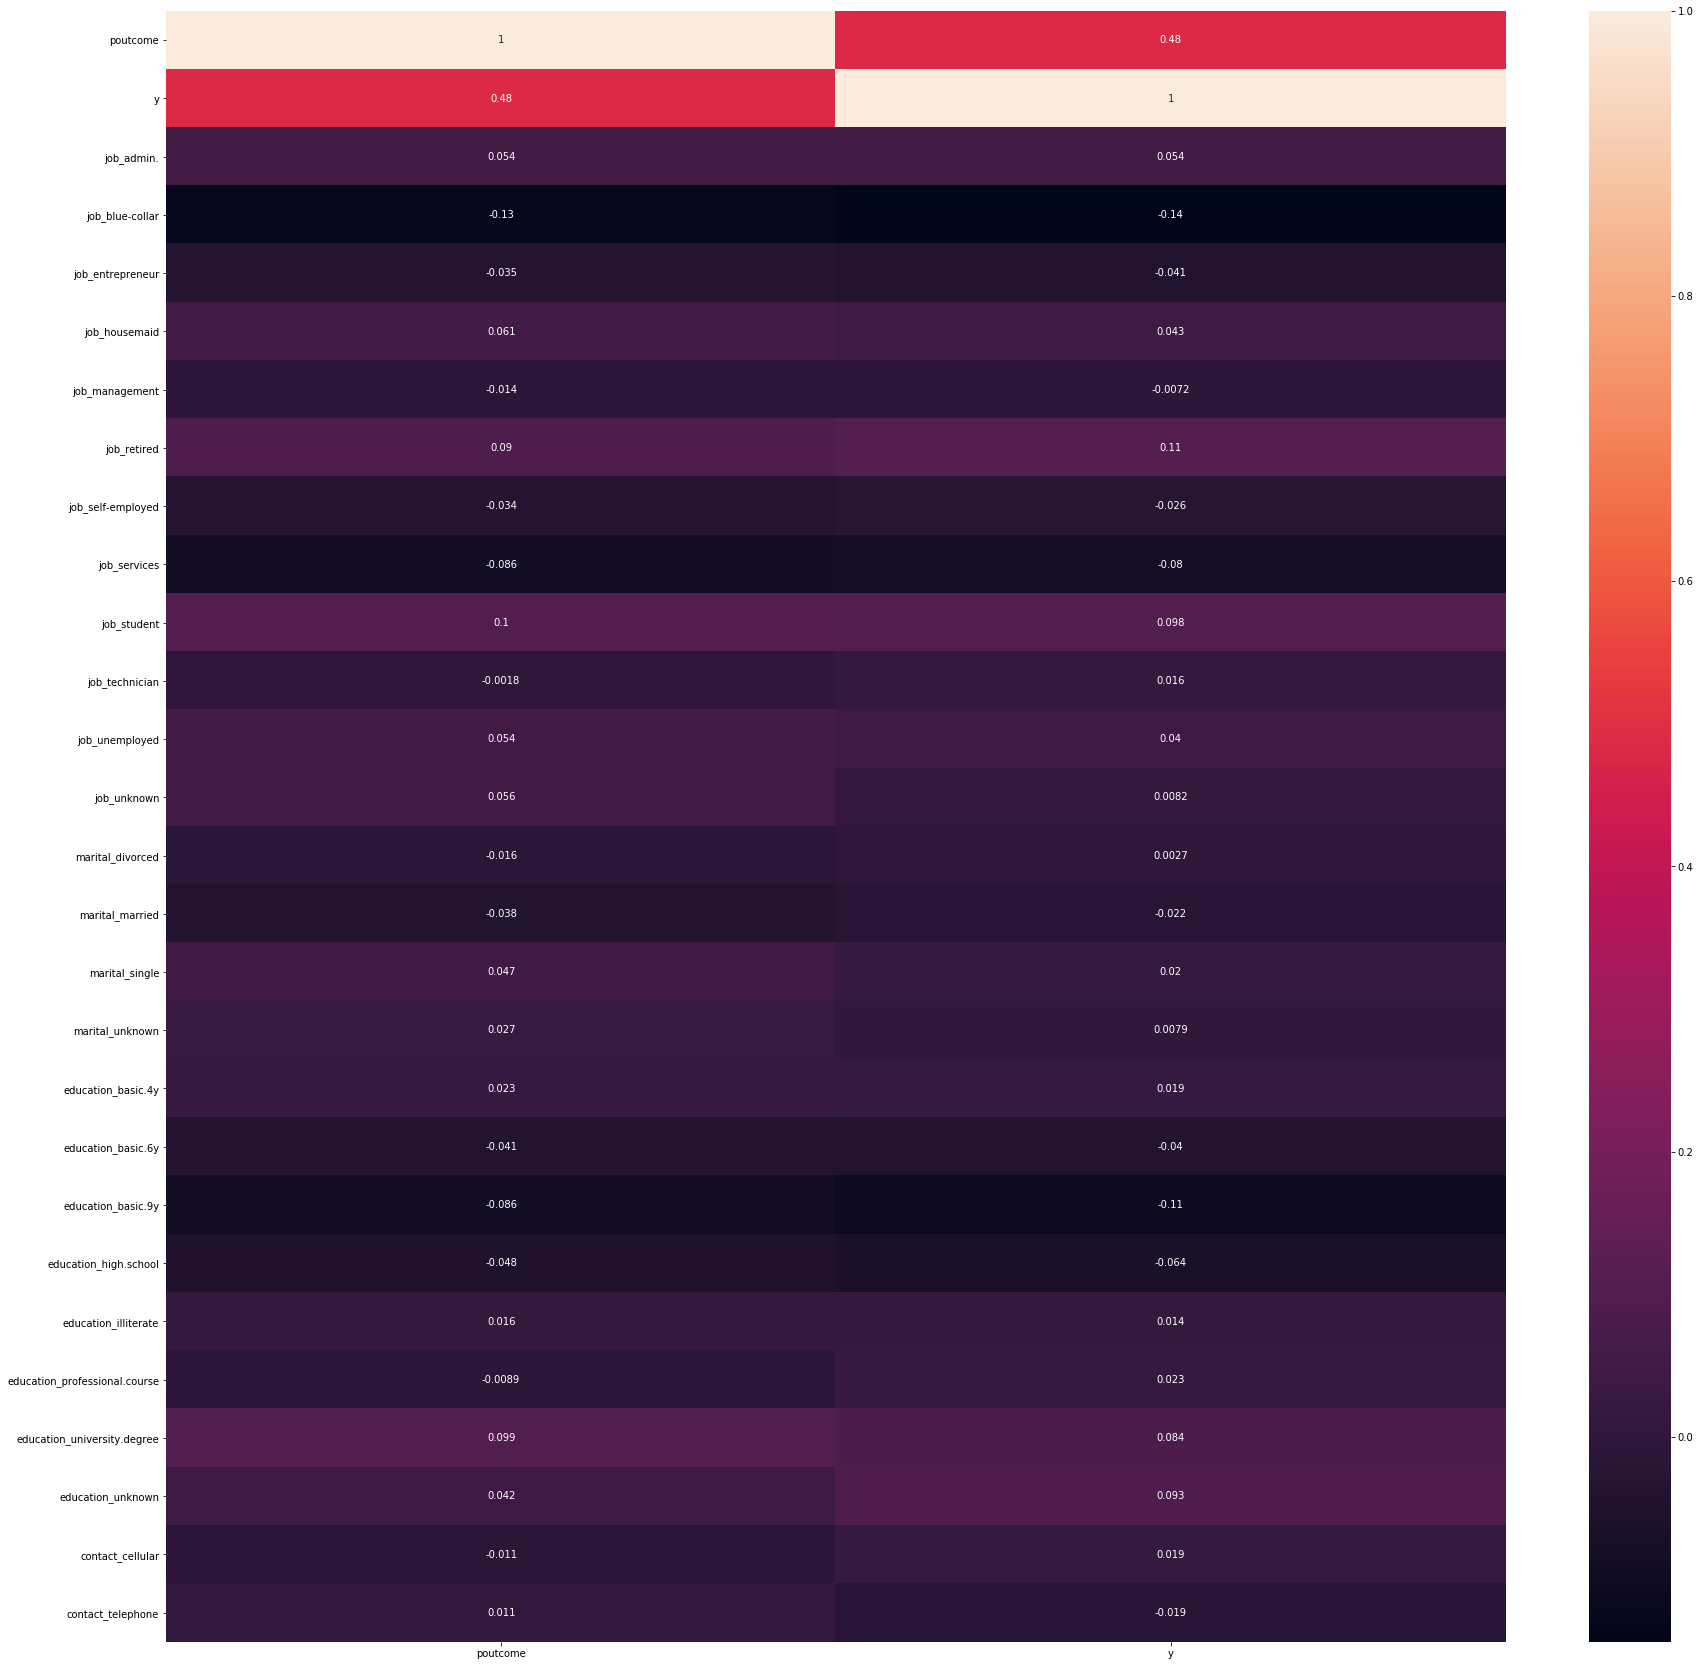

In [16]:
# Set of sample witho known y and poutcome
pd_poutcome_y = pd_poutcome.loc[pd_poutcome['y'] != -1]
corr = pd.DataFrame(pd_poutcome_y.corr()[['poutcome','y']])
fig, ax = plt.subplots(figsize=(30,30))   
svm = sn.heatmap(corr, annot=True)
fig.savefig('./poutcome_&_y.png', dpi=200)



import pandas as pd
import numpy as np


def get_data(path):
    data = pd.read_csv(path)

    # ID
    test_ids = data[data['y'] == 'unknown']['id']
    data = data.replace(
        {'y': {'yes': 1, 'no': 0, 'unknown': -1}})
    data.drop('id', axis=1, inplace=True)
    ### PRZY ZOSTAWIENIU KOLUMNY ID, model osiąga znacznie lepsze rezultaty

    # CONTACT_DATE
    reference_data = pd.Timestamp(data['contact_date'].max())
    data['days_since_last_contact'] = (
            reference_data - pd.to_datetime(data['contact_date'])).dt.days
    data['days_since_last_contact'] = (data['days_since_last_contact'] -
                                       data['days_since_last_contact'].mean()) / data[
                                          'days_since_last_contact'].std()
    data.drop('contact_date', axis=1, inplace=True)

    # BIRTH_DATE
    data['age'] = ((reference_data - pd.to_datetime(data['birth_date'])).dt.days / 365).astype(int)
    data['age'] = ((reference_data - pd.to_datetime(data['birth_date'])).dt.days / 365).astype(int)
    data.drop('birth_date', axis=1, inplace=True)
    # data.drop('age', axis=1, inplace=True)

    # Usunąłem kolumnę kontakt, pomimo silnej korelacji z wynikiem, z powodu nikłego logicznego powiazania,
    # używanie konretnego typu telefonu nie było powiązane z grupą wiekową ani zawodową

    # CONTACT
    # data.loc[data['contact'] == 'cellular', 'contact'] = 1
    # data.loc[data['contact'] == 'telephone', 'contact'] = 0
    data.drop('contact', axis=1, inplace=True)
    # data['contact'] = pd.factorizef(data['contact'])[0]

    # JOB
    tmp = data['job']
    data['job'] = 1
    data.loc[tmp == 'blue-collar', 'job'] = 0
    data.loc[tmp == 'services', 'job'] = 1
    data.loc[tmp == 'entrepreneur', 'job'] = 1
    data.loc[tmp == 'management', 'job'] = 1
    data.loc[tmp == 'self-employed', 'job'] = 1
    data.loc[tmp == 'housemaid', 'job'] = 1
    data.loc[tmp == 'technician', 'job'] = 1
    data.loc[tmp == 'unknown', 'job'] = 2
    data.loc[tmp == 'admin', 'job'] = 2
    data.loc[tmp == 'unemployed', 'job'] = 3
    data.loc[tmp == 'retired', 'job'] = 4
    data.loc[tmp == 'student', 'job'] = 7

    # kolejność numerów zgodnie z korelacją do sukcesu

    # na początku zostawiłem tylko informację czy klient był kontaktowany w ostatniej kampani,
    # później zrezygnowałem z tego featchera
    # PDAYS
    # data.loc[data['pdays'] == 999, ['pdays']] = 1
    # data.loc[data['pdays'] != 1, ['pdays']] = -1
    data.drop('pdays', axis=1, inplace=True)

    # MARITAL
    data.loc[data['marital'] == 'divorced', 'marital'] = 1
    data.loc[data['marital'] == 'married', 'marital'] = 0
    data.loc[data['marital'] == 'unknown', 'marital'] = 3
    data.loc[data['marital'] == 'single', 'marital'] = 2

    # numery zgodne z korelacją do wyniku

    # LOAN
    data = data.replace(
        {'loan': {'yes': 1, 'no': 0, 'unknown': np.nan}})
    # data = pd.get_dummies(data, columns=['loan'])
    # data['loan'] = pd.factorize(data['loan'])[0]
    # dat/a.drop('loan', axis=1, inplace=True)

    # HOUSING
    data = data.replace(
        {'housing': {'yes': 1, 'no': 0, 'unknown': np.nan}})
    # data = pd.get_dummies(data, columns=['housing'])
    # data['housing'] = pd.factorize(data['housing'])[0]
    # data.drop('housing', axis=1, inplace=True)


    # DEFAULT
    # data = pd.get_dummies(data, columns=['default'])
    # data = data.replace(
    #     {'default': {'yes': 1, 'no': 0, 'unknown': -1}})
    # data['default'] = pd.factorize(data['default'])[0]

    #usunięcie kolumny, bo ilość osób które zalegały z odsetkami jest pomijalnie mała
    data.drop('default',axis=1,inplace=True)

    # dodanie informacji czy posiada jakikolwiek kredyt
    data['credit'] = 0
    data.loc[data['housing'] == 1, 'credit'] = 1
    data.loc[data['housing'] == 1, 'credit'] = data['credit'] + 1


    # POUTCOME
    # data = pd.get_dummies(data, columns=['poutcome'])
    # data.drop('poutcome_failure',axis=1, inplace=True)
    data = data.replace(
        {'poutcome': {'success': 1, 'failure': 0, 'nonexistent': np.nan}})
    # data['poutcome'] = pd.factorize(data['poutcome'])[0]

    # EDUCATION
    # data['education'] = pd.factorize(data['education'])[0]
    # data = pd.get_dummies(data, columns=['education'])
    data.loc[data['education'] == 'basic.6y', 'education'] = 0
    data.loc[data['education'] == 'basic.9y', 'education'] = 1
    data.loc[data['education'] == 'basic.4y', 'education'] = 2
    data.loc[data['education'] == 'professional.course', 'education'] = 3
    data.loc[data['education'] == 'high.school', 'education'] = 4
    data.loc[data['education'] == 'university.degree', 'education'] = 5
    data.loc[data['education'] == 'illiterate', 'education'] = 6
    data.loc[data['education'] == 'unknown', 'education'] = 7

    # PREVIOUES
    # data.drop('previous', axis=1, inplace=True)


    # NEW_FEATURE
    # zamiana wieku na grupy wiekowe
    data['group_age' ] = pd.to_numeric(pd.cut(data['age'], np.arange(15,101,5),labels=[i for i in range (17)]))
    data.drop('age',axis=1,inplace=True)

    # dodanie jak bardzo klient jest aktywny
    data['sum_of_contact'] = data['campaign'] + data['previous']

    # porównanie aktywności w tej campani do starej aktywnosci
    data['%_new_contacts'] = data['campaign'] / data['previous']

    dataset = data[data['y'] != -1]

    dataset['y'] = pd.to_numeric(dataset['y'])
    test_data = data[data['y'] == -1].drop("y", axis=1)

    return dataset, test_data, test_ids


def get_input_output(data):
    output = data['y']
    input = data.drop('y', axis=1)
    return input, output




/home/abs/Projects/ML_JNP/venv/lib/python3.6/site-packages/ipykernel_launcher.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


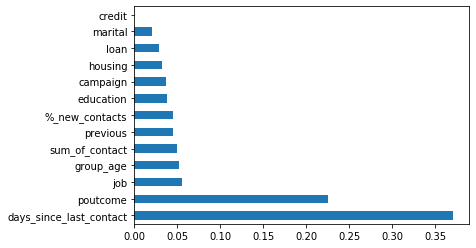

In [19]:
random_state = 12431234

dataset, x_test_data, test_ids = get_data("./data/bank-classification.csv")

x_dataset, y_dataset = get_input_output(dataset)
x_train, x_test, y_train, y_test = train_test_split( x_dataset, y_dataset, test_size=0.3, random_state=random_state)
dtrain = xgb.DMatrix(x_dataset,label=y_dataset)

params_choosen ={'objective': 'binary:logistic', 'max_depth': 4, 'learning_rate': 0.06245355829212278, 'subsample': 0.8, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'min_child_weight': 0.5, 'gamma': 0, 'alpha': 1.0, 'n_estimators': 70}


#Wynik osiągnięty: 0.79441
#Wynik osiągany przy zostawieniu kolumny id: 0.80368
# Nie spodziewałęm sie, że identyfikator może wpływać na wynik, szczególnie, że nie jest opisany na stronie,
# spędziłem wiele dni na upradowaniu modelu bez identyfikatora, spradzałem inne modele, wykonywałem ensembling,
# bez skutecznie.


xg_reg = xgb.XGBClassifier(**params_choosen)
xg_reg.fit(x_dataset, y_dataset,eval_metric=['auc'],verbose=50)
y_pred = xg_reg.predict_proba(x_test_data)[:,1]
save_scores_to_file(y_pred,test_ids,'result_odt')
(pd.Series(xg_reg.feature_importances_, index=x_dataset.columns)
 .nlargest(100)
 .plot(kind='barh'))

In [18]:
cv_results = xgb.cv(dtrain=dtrain, params=params_choosen, nfold=10, shuffle=True,  num_boost_round=params_choosen['n_estimators'], metrics='auc', as_pandas=True, seed=0,early_stopping_rounds=100,verbose_eval=100)
print(cv_results["test-auc-mean"].max())
print(cv_results[['test-auc-mean']].idxmax())

[0]	train-auc:0.767012+0.00445382	test-auc:0.764642+0.0111864
[69]	train-auc:0.807806+0.00159764	test-auc:0.788083+0.0122675
0.7885624
test-auc-mean    53
dtype: int64


In [21]:
import random

param_grid = {
        'objective': ['binary:logistic'],
        'max_depth': [3,4,5],
        'learning_rate': np.random.uniform(low=0.0001,high=0.3,size=1000),
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'alpha': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators':[1000],
}

number_iter = 2
i = 0
best_params = 0
best_scores = 0

for  i in  range(number_iter):
    params = {}
    for k in param_grid.keys():
        params[k] = random.choice(param_grid[k])
    
    cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=10,   num_boost_round=params['n_estimators'], metrics='auc', as_pandas=True,early_stopping_rounds=50,verbose_eval=100)
    score = cv_results["test-auc-mean"].max()
    n_iter = cv_results[['test-auc-mean']].idxmax()
    params['n_estimators'] = n_iter
    if score > best_scores:
        best_scores = score
        best_params=params
    print(i,score)
    print(params)
    print('BEST:',best_scores,best_params)
print(best_params,best_scores)

[0]	train-auc:0.714863+0.00179831	test-auc:0.713441+0.00781954
[100]	train-auc:0.788993+0.00139185	test-auc:0.784842+0.0112565
0 0.7849303999999999
{'objective': 'binary:logistic', 'max_depth': 3, 'learning_rate': 0.23811589910760833, 'subsample': 0.7, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'min_child_weight': 0.5, 'gamma': 0.25, 'alpha': 50.0, 'n_estimators': test-auc-mean    113
dtype: int64}
BEST: 0.7849303999999999 {'objective': 'binary:logistic', 'max_depth': 3, 'learning_rate': 0.23811589910760833, 'subsample': 0.7, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'min_child_weight': 0.5, 'gamma': 0.25, 'alpha': 50.0, 'n_estimators': test-auc-mean    113
dtype: int64}
[0]	train-auc:0.709784+0.000795042	test-auc:0.708778+0.00663007
[100]	train-auc:0.774746+0.00165773	test-auc:0.772377+0.0115193
[200]	train-auc:0.778595+0.00172857	test-auc:0.773208+0.01206
1 0.7734537999999999
{'objective': 'binary:logistic', 'max_depth': 4, 'learning_rate': 0.04783167543949985, 'subs